<h1> Optical character recognition using keras</h1>
<h3> Dataset used : Chars74k</h3>
<h3> link: <a>http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/</a></h3>
<h3>Dataset contained 0-9, A-Z, a-z</h3>
<h3>Dataset comprised of 4 computer fonts in normal, bold, italic </h3>
<p>I used 80% data for training, 15% for validation and 5% for testing. The accuracy achieved is as follows:<br>
<br>
Training : 98.11%<br>
Validation: 94.66%<br>
Test: 94.77%<br></p>

In [0]:
#import packages
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import numpy as np
import math
import os
from shutil import copyfile

In [6]:
import keras
from keras.models import Sequential
from keras.layers import Dense

from keras.preprocessing.image import ImageDataGenerator

from keras.models import load_model

from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

from keras.layers import Flatten

Using TensorFlow backend.


In [7]:
#get the dataset for ocr
!wget http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishFnt.tgz

--2020-04-22 21:28:46--  http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishFnt.tgz
Resolving www.ee.surrey.ac.uk (www.ee.surrey.ac.uk)... 131.227.80.48
Connecting to www.ee.surrey.ac.uk (www.ee.surrey.ac.uk)|131.227.80.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49817950 (48M) [application/x-gzip]
Saving to: ‘EnglishFnt.tgz’

EnglishFnt.tgz      100%[===================>]  47.51M  15.9MB/s    in 3.0s    

2020-04-22 21:28:50 (15.9 MB/s) - ‘EnglishFnt.tgz’ saved [49817950/49817950]



In [0]:
#unzip the dataset
!tar -xvzf EnglishFnt.tgz

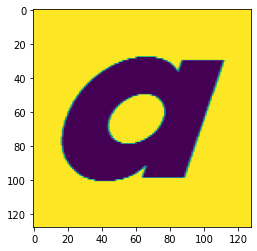

In [10]:
#view an image sample
imgsample = Image.open('English/Fnt/Sample037/img037-00008.png')
npsample = np.array(imgsample)
plt.imshow(npsample)

<h1>PREPROCESSING</h1>

In [0]:
#create train, valid and test directories
if not os.path.isdir('dataset'):
  os.mkdir('dataset')

if not os.path.isdir('dataset/train'):
  os.mkdir('dataset/train')
if not os.path.isdir('dataset/valid'):
  os.mkdir('dataset/valid')
if not os.path.isdir('dataset/test'):
  os.mkdir('dataset/test')

In [0]:
#make class directories inside them
for i in sorted(os.listdir('English/Fnt')):
  if not os.path.isdir('dataset/train/'+i):
    os.mkdir('dataset/train/'+i)
  if not os.path.isdir('dataset/valid/'+i):
    os.mkdir('dataset/valid/'+i)
  if not os.path.isdir('dataset/test/'+i):
    os.mkdir('dataset/test/'+i)

In [0]:
#split main folder to train, valid, test and copy images to the new folders
base = 'English/Fnt/Sample'

for char  in range(1, 63):
  classLen = len(os.listdir(base + str(char).zfill(3)))

  trainLen = math.floor(classLen*0.80)
  validLen = math.ceil(classLen*0.15)

  randFnt = np.random.randint(low = 1, high = classLen, size = classLen)
  randTrain = randFnt[:trainLen]
  randValid = randFnt[trainLen : trainLen+validLen]
  randTest = randFnt[trainLen+validLen :]

  for imgNo in randTrain:
    src = base+str(char).zfill(3)+'/img'+str(char).zfill(3)+'-'+str(imgNo).zfill(5)+'.png'
    des = 'dataset/train/Sample'+str(char).zfill(3)+'/img'+str(char).zfill(3)+'-'+str(imgNo).zfill(5)+'.png'
    copyfile(src, des)

  for imgNo in randValid:
    src = base+str(char).zfill(3)+'/img'+str(char).zfill(3)+'-'+str(imgNo).zfill(5)+'.png'
    des = 'dataset/valid/Sample'+str(char).zfill(3)+'/img'+str(char).zfill(3)+'-'+str(imgNo).zfill(5)+'.png'
    copyfile(src, des)

  for imgNo in randTest:
    src = base+str(char).zfill(3)+'/img'+str(char).zfill(3)+'-'+str(imgNo).zfill(5)+'.png'
    des = 'dataset/test/Sample'+str(char).zfill(3)+'/img'+str(char).zfill(3)+'-'+str(imgNo).zfill(5)+'.png'
    copyfile(src, des)


<h1>MODEL CREATION</h1>

In [0]:
#define constants
num_classes = 62
image_resize = 128
batch_size_training = 128
batch_size_validation = 64

In [0]:
#create data generator
data_generator = ImageDataGenerator(rescale=1.0/255.0)

In [21]:
#create train and valid generators
train_generator = data_generator.flow_from_directory(
    'dataset/train',
    target_size = (image_resize, image_resize),
    batch_size = batch_size_training,
    color_mode = 'grayscale',
    class_mode = 'categorical'
)

validation_generator = data_generator.flow_from_directory(
    'dataset/valid',
    target_size = (image_resize, image_resize),
    batch_size = batch_size_training,
    color_mode = 'grayscale',
    class_mode = 'categorical'
)

Found 34618 images belonging to 62 classes.
Found 8823 images belonging to 62 classes.


In [22]:
#view batch specifications
batchX, batchy = train_generator.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batch shape=(128, 128, 128, 1), min=0.000, max=1.000


In [0]:
#This is the best model i could create.
#Because for other cases, the improvement was minimal compared to the additional computational cost.

In [0]:
#create the model
def ocrModel():
  model = Sequential()
  model.add(Conv2D(32, (4,4), strides = (1,1), activation = 'relu', input_shape = (128, 128, 1)))
  model.add(MaxPooling2D(pool_size = (4,4), strides = (2,2)))
  model.add(Conv2D(64, (4,4), strides = (1,1), activation = 'relu', input_shape = (128, 128, 1)))
  model.add(MaxPooling2D(pool_size = (4,4),strides = (2,2)))

  model.add(Flatten())

  model.add(Dense(310, activation='relu'))
  model.add(Dense(num_classes, activation = 'softmax'))

  model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])

  return model

In [0]:
#parameters for fitting
steps_per_epoch_training = len(train_generator)
steps_per_epoch_validation = len(train_generator)
num_epochs = 20

In [76]:
model = ocrModel()

#view model summary
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 125, 125, 32)      544       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 58, 58, 64)        32832     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 50176)             0         
_________________________________________________________________
dense_38 (Dense)             (None, 310)               15554870  
_________________________________________________________________
dense_39 (Dense)             (None, 62)              

<h1>FIT MODEL</H1>

In [60]:
#fit model
fit_history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch_training,
    epochs = num_epochs,
    validation_data = validation_generator,
    validation_steps = steps_per_epoch_validation,
    verbose = 1
)

Epoch 1/20
271/271 [==============================] - 38s 140ms/step - loss: 1.1120 - accuracy: 0.7155 - val_loss: 0.3850 - val_accuracy: 0.8614
Epoch 2/20
271/271 [==============================] - 38s 139ms/step - loss: 0.3896 - accuracy: 0.8719 - val_loss: 0.3193 - val_accuracy: 0.9008
Epoch 3/20
271/271 [==============================] - 38s 138ms/step - loss: 0.2562 - accuracy: 0.9081 - val_loss: 0.3161 - val_accuracy: 0.9124
Epoch 4/20
271/271 [==============================] - 38s 138ms/step - loss: 0.1984 - accuracy: 0.9268 - val_loss: 0.1398 - val_accuracy: 0.9236
Epoch 5/20
271/271 [==============================] - 38s 139ms/step - loss: 0.1653 - accuracy: 0.9384 - val_loss: 0.2262 - val_accuracy: 0.9311
Epoch 6/20
271/271 [==============================] - 38s 139ms/step - loss: 0.1409 - accuracy: 0.9479 - val_loss: 0.2580 - val_accuracy: 0.9335
Epoch 7/20
271/271 [==============================] - 38s 139ms/step - loss: 0.1306 - accuracy: 0.9507 - val_loss: 0.3015 - val_ac

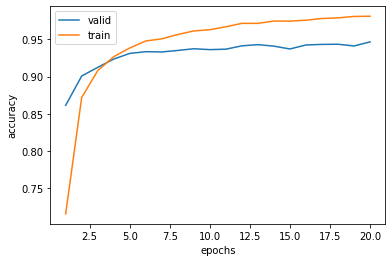

In [62]:
#plot the fitting history
plt.plot(range(1,21), fit_history.history['val_accuracy'], label='valid')
plt.plot(range(1,21), fit_history.history['accuracy'], label='train')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

<h1>TEST MODEL</h1>

In [65]:
#define test generator
test_generator = data_generator.flow_from_directory(
    'dataset/test',
    target_size = (image_resize, image_resize),
    shuffle = False,
    color_mode='grayscale'
)

Found 3080 images belonging to 62 classes.


In [66]:
#evaluate the model
eval = model.evaluate_generator(test_generator, verbose=1)
print('Model performance:')
print('loss for test dataset is : {}'.format(eval[0]))
print('accuracy for test dataset is : {}'.format(eval[1]))

97/97 [==============================] - 1s 13ms/step
Model performance:
loss for test dataset is : 0.0007697362452745438
accuracy for test dataset is : 0.9477272629737854


In [67]:
#connect to your google drive
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#save model to google drive
model.save('/content/gdrive/My Drive/keras_models/OCRmodel.h5')

In [0]:
#to copy from drive
#!cp /content/gdrive/My\ Drive/keras_models/classifier_resnet_model.h5 ./classifier_resnet_model.h5

<h1> TEST MODEL ON OWN FILES</h1>

In [70]:
#upload files from local storage
from google.colab import files
uploaded = files.upload()

Saving 8.png to 8.png
Saving 7.png to 7.png
Saving 6.png to 6.png
Saving 5.png to 5.png
Saving 4.png to 4.png
Saving 3.png to 3.png
Saving 2.png to 2.png
Saving 1.png to 1.png


In [0]:
#create a label map
classArr = [str(i) for i in range(10)]
classArr.extend([chr(i) for i in range(ord('A'), ord('Z')+1)])
classArr.extend([chr(i) for i in range(ord('a'), ord('z')+1)])

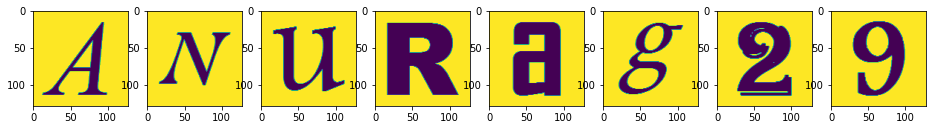

In [71]:
#view the text images to be detected
fig, axs = plt.subplots(1,8, figsize = (16,5))

for i in range(8): 
    image_data = Image.open(str(i+1)+'.png')
    axs[i].imshow(image_data)

In [74]:
#detect text using model
res = ''
for i in range(1,9):
  img = Image.open(str(i)+'.png')
  imgnp = np.array(img)
  imgnp = np.reshape(imgnp, (1,imgnp.shape[0],imgnp.shape[1], 1))
  predict = model.predict_classes(imgnp)
  res += classArr[predict[0]]

print(res)

ANuRag29
